# Modelling the product of two distributions with spatial autocorrelation
As we had discussed previously, the GBIF data is of the type *presence-only* this means that we don't know for sure when a given species es really abscent or simply the has not been registered in that location. 
We may model this as:



In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import pymc3 as pm

## Use the ggplot style
plt.style.use('ggplot')

/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
datatrain = pd.read_csv("/outputs/sample_fams_bats.csv")
datatrain = pd.read_csv("/outputs/training_dataset_complete_with_socioeconomical.csv")
## Read Predictors
datapred = pd.read_csv('/outputs/sample_predictors_complete.csv')
datacube_clean = datapred.dropna()

In [3]:
len(datapred.columns)

17

In [4]:
datatrain.columns

Index([u'Unnamed: 0', u'Y', u'DistanceToRoadMex_mean', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'WorldPopLatam2010_mean', u'Longitude', u'Latitude',
       u'vegid', u'vegname'],
      dtype='object')

In [5]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


In [6]:
vegname = datatrain[['vegid','vegname']]

In [7]:
gv = vegname.groupby('vegid')
gv.first()

,vegname
vegid,
1,Tropical and Subtropical Moist Broadleaf Forests
2,Tropical and Subtropical Dry Broadleaf Forests
3,Tropical and Subtropical Coniferous Forests
7,"Tropical and Subtropical Grasslands, Savannas ..."
12,"Mediterranean Forests, Woodlands and Scrub"
13,Deserts and Xeric Shrublands
14,Mangroves


In [8]:
## Convert to geopandas
## drop non real fields. this is important for the model
datatrain.drop(['vegname'],axis=1,inplace=True)

from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')
datafull = datatrain.replace('N.A.',np.nan).astype('float')
Y = datafull.Y


/apps/external_plugins/spystats/spystats/tools.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['geometry'] = data.apply(lambda z : Point(z[xcoord_name], z[ycoord_name]), axis=1)


In [9]:
datapred.columns

Index([u'Unnamed: 0', u'MaxTemperature', u'SolarRadiation', u'Elevation',
       u'MinTemperature', u'WorldPopLatam2010', u'WindSpeed',
       u'DistanceToRoadMex', u'MeanTemperature', u'Vapor', u'Precipitation',
       u'Longitude', u'Latitude', u'vegid', u'vegname', u'inegiv5id',
       u'inegiv5name'],
      dtype='object')

In [10]:
datatrain.columns

Index([u'Unnamed: 0', u'Y', u'DistanceToRoadMex_mean', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'WorldPopLatam2010_mean', u'Longitude', u'Latitude',
       u'vegid'],
      dtype='object')

In [12]:
## This is for calculating the signal

from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model:

    ## [R | Y]

    tau = pm.HalfNormal('tau',sd=10)
    sigma = pm.HalfNormal('sigma',sd=10)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1])) + Tau

    ## Parameters for linear predictor
    #b0 = pm.Normal('b0',mu=0,sd=10)
    b = pm.Normal('b',mu=0,sd=10,shape=3)
    mf = pm.gp.mean.Linear(coeffs=[b]) 

    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("latent_field", X=datafull[['Longitude','Latitude','DistanceToRoadMex_mean','WorldPopLatam2010_mean','vegid']].values,reparameterize=False)


    ## Other model M2
    
    beta_y = pm.Normal("betay",mu=0, sd=10,shape=2)
    
    theta = beta_y[0] + beta_y[1] * datafull.MaxTemperature_mean.values
    
    yy = pm.Bernoulli("yy",logit_p=theta,observed=Y.values)
    
    
    #y_obs = pm.Bernoulli('y_obs',logit_p=(f*yy),observed=Y.values)
    
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)


   # %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','DistanceToRoadMex','WorldPopLatam2010','vegid']].values)
  
   # pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)

   

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 431.59: 100%|██████████| 15000/15000 [02:57<00:00, 84.64it/s]
Finished [100%]: Average Loss = 431.4
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 431.4


CPU times: user 11min 27s, sys: 14.8 s, total: 11min 42s
Wall time: 3min 20s
CPU times: user 1.89 s, sys: 76 ms, total: 1.97 s
Wall time: 2.08 s


In [130]:
## This is for calculating the signal

from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model_1:

        
    Yt = datafull.MaxTemperature_mean
    Y = datafull.Y
    
   
    #b = pm.Normal('b',mu=0,sd=1,shape=3)

    
    beta_1 = pm.Normal("betay",mu=0, sd=10,shape=1)
    theta_1 = beta_1[0] * datafull.MaxTemperature_mean.values
    
    #m1 = pm.Normal("yy",mu=beta_1)
    
    beta_2 = pm.Normal("beta2",mu=0,sd=5,shape=1)
    theta_2 = beta_2[0] * datafull.DistanceToRoadMex_mean.values
    
    pp = pm.Deterministic('aux',theta_1 + theta_2)
    #m2 = pm.Normal("yy2",theta2)
    
    
    
    yy = pm.Bernoulli("yy",logit_p=pp,observed=Y.values)
    
    
  
    

   # %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','DistanceToRoadMex','WorldPopLatam2010','vegid']].values)
  
   # pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)



In [131]:
with model_1 :
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)
    mapp = pm.find_MAP()

Average Loss = 18,484: 100%|██████████| 15000/15000 [00:17<00:00, 869.09it/s]
Finished [100%]: Average Loss = 18,497
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 18,497


CPU times: user 16 s, sys: 1.21 s, total: 17.2 s
Wall time: 22.2 s
CPU times: user 1.85 s, sys: 76 ms, total: 1.93 s
Wall time: 1.92 s


logp = -202.07, ||grad|| = 13,039: 100%|██████████| 27/27 [00:00<00:00, 868.34it/s]   


In [132]:
mapp

{'aux': array([-0.54287938, -0.43538195, -0.59101993, -0.46890584, -0.50543496,
        -0.70991497, -0.54621126, -0.66606668, -0.36017042, -0.46305545,
        -0.50039655, -0.57185025, -1.04050489, -0.72862941, -0.98548483,
        -0.79559725, -0.42179575, -0.45233914, -0.48289757, -0.4863701 ,
        -0.52854872, -0.57218925, -0.42922709, -0.36310007, -0.56826647,
        -0.71067214, -0.76943823, -0.34505579, -0.46811879, -0.59133107,
        -0.57065381, -0.5845353 , -0.74609382, -0.73858669, -0.31886464,
        -0.95156691, -0.34183185, -0.45069353, -0.5182213 , -0.68351971,
        -0.5096356 , -0.53085812, -0.74372985, -0.61943781, -0.34843788,
        -0.41901856, -0.66604663, -0.50465818, -0.50048085, -0.41861815,
        -0.55321563, -0.61911594, -0.55157343, -0.44838759, -0.52941834,
        -0.43008167, -0.57871773, -0.44460477, -0.48318251, -0.48991256,
        -0.38951031, -0.55435582, -0.51365221, -0.33100664, -0.5099202 ,
        -0.4054338 , -0.41339204, -0.5162022

In [133]:
with model_1:
    trace_1 = pm.sample(50,chains=2,nuts_kwargs=dict(target_accept=.5),tune=30)
    mapp = pm.find_MAP()

Only 50 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta2, betay]
INFO:pymc3:NUTS: [beta2, betay]
100%|██████████| 80/80 [00:00<00:00, 622.64it/s]There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 6.613861039524613e-33, but should be close to 0.5. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.11120496714228897, but shou

In [134]:
mapp

{'aux': array([-0.54287938, -0.43538195, -0.59101993, -0.46890584, -0.50543496,
        -0.70991497, -0.54621126, -0.66606668, -0.36017042, -0.46305545,
        -0.50039655, -0.57185025, -1.04050489, -0.72862941, -0.98548483,
        -0.79559725, -0.42179575, -0.45233914, -0.48289757, -0.4863701 ,
        -0.52854872, -0.57218925, -0.42922709, -0.36310007, -0.56826647,
        -0.71067214, -0.76943823, -0.34505579, -0.46811879, -0.59133107,
        -0.57065381, -0.5845353 , -0.74609382, -0.73858669, -0.31886464,
        -0.95156691, -0.34183185, -0.45069353, -0.5182213 , -0.68351971,
        -0.5096356 , -0.53085812, -0.74372985, -0.61943781, -0.34843788,
        -0.41901856, -0.66604663, -0.50465818, -0.50048085, -0.41861815,
        -0.55321563, -0.61911594, -0.55157343, -0.44838759, -0.52941834,
        -0.43008167, -0.57871773, -0.44460477, -0.48318251, -0.48991256,
        -0.38951031, -0.55435582, -0.51365221, -0.33100664, -0.5099202 ,
        -0.4054338 , -0.41339204, -0.5162022

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1616bcda90>,
      dtype=object)

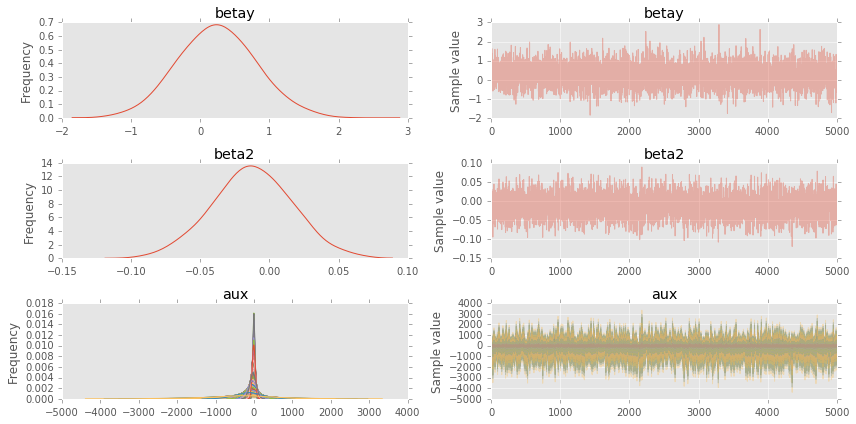

In [135]:

pm.traceplot(trace)

In [ ]:
corr = datatrain.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(datatrain.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(datatrain.columns)
ax.set_yticklabels(datatrain.columns)
plt.show()

In [ ]:
from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)
elevation = RasterData(rastermodelinstance=MeanTemperature,border=Mexico.geom)
#Rescale to fit same number of pixels
pixel_size = 0.25
elevation.rescale(pixel_size)
elevation.display_field(origin='Lower')

preds = pd.DataFrame(pred_samples['f_star']).transpose()




In [ ]:
## Calculate some summary statistics
import scipy.special as sp
alpha = sp.logit(0.5) 
mean_sample = preds.mean(axis=1)
q_025 = preds.quantile(0.025,axis=1)
q_975 = preds.quantile(0.975,axis=1)
prob_gt05 = preds.apply(lambda row : float(sum(row > alpha))/100,axis=1)
surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975,'prob_gt05':prob_gt05})

In [ ]:
surface_data['idx'] = datacube_clean.index.values
predictions = datapred.merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
predicted_data = predictions.mean_sample.values
mean = RasterContainer(predictions.q_025.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
ql_presences_of_something = RasterContainer(predictions.mean_sample.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")


In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(ql_presences_of_something.rasterdata.bands[1].data(),origin='Lower',vmin=0.0,vmax=1.0)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("Mean probability field")
plt.colorbar(orientation='horizontal')

In [ ]:
## With pcolor
M = ql_presences_of_something.rasterdata.bands[1].data()
minx = predictions.Latitude.min()
maxx = predictions.Latitude.max()
miny = predictions.Longitude.min()
maxy = predictions.Longitude.max()
i,j = M.shape
#np.meshgrid

In [ ]:
#X = np.linspace(minx,maxx,j)
#Y = np.linspace(miny,maxy,i)
#XX,YY = np.meshgrid(X,Y)

In [ ]:
ql_025 = RasterContainer(predictions.q_025.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(ql_025.rasterdata.bands[1].data(),origin='Lower',interpolation='None',vmin=0.0,vmax=1.0)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("q025 probability field")

plt.colorbar(orientation='horizontal')

In [ ]:
ql_97 = RasterContainer(predictions.q_975.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(ql_97.rasterdata.bands[1].data(),origin='Lower',vmin=0.0,vmax=1.0)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("q97 probability field")
plt.colorbar(orientation='horizontal')

## Exceeding probability


In [ ]:
## Probability of the probaaility of presences bigger than 0.5
prob5 = RasterContainer(predictions.prob_gt05.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
#prob5.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(prob5.rasterdata.bands[0].data(),origin='Lower',vmin=0.0,vmax=1.0,cmap=plt.cm.RdBu)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("Exceeding Probability field")
plt.colorbar(orientation='horizontal')


In [ ]:
ql_025.exportToGeoTiff("q025_signal")
ql_97.exportToGeoTiff("q97_signal")

In [ ]:
## Visualizing distance to road map
#from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature,DistanceToRoadMex
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)
distroad = RasterData(rastermodelinstance=DistanceToRoadMex,border=Mexico.geom)
#distroad.display_field()

In [ ]:
distroad.getRaster()

In [ ]:
distroad.display_field()

In [ ]:
#ql_presences_of_something.exportToGeoTiff("mean_signal")